Diferencias:
- Se eliminó las variables que no estuvieran correlacionadas con el objetivo.
- Se utilizó un escalado min_max

In [197]:
from dotenv import load_dotenv
import os

# Cargar automáticamente las variables del archivo .env
load_dotenv()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_RAW = os.getenv('DATA_RAW')
DATA_PREPROCESSED = os.getenv('DATA_PROCESSED')
MODELS = os.getenv('MODELS')
# df_train = pd.read_csv(os.path.join('..',DATA_PREPROCESSED, "dataframe_train.csv"), sep=";")
# df_test = pd.read_csv(os.path.join('..',DATA_PREPROCESSED, "dataframe_test.csv"), sep=";")
df = pd.read_csv(os.path.join('..',DATA_RAW, "dataframe_merged.csv"), sep=";")

Terminar de ajustar el dataset

In [198]:
#Se comprobó previamente que ciertas columans no serán útiles:
df.drop(
    ['dew_point',
'feels_like',
'temp_min',
'temp_max',
'weather_description',
'weather_main',
'Total Cantidad',
'Unnamed: 81',
'dt_iso'], axis= 1, inplace=True
)
y = df[[f'Sabor {i}' for i in range(1, 80)]]
X = df.drop([f'Sabor {i}' for i in range(1, 80)], axis = 1)
#Agregamos algunas columnas de fecha que podrían tener información sobre tendencias

X['Ajuste Fecha'] = pd.to_datetime(X['Ajuste Fecha'])
X['year'] = X['Ajuste Fecha'].dt.year
X['month'] = X['Ajuste Fecha'].dt.month
X['day'] = X['Ajuste Fecha'].dt.day
# Número de semana ISO (1-53) — lunes es el primer día de la semana
X['week'] = X['Ajuste Fecha'].dt.isocalendar().week      # tipo UInt32
X['week'] = X['week'].astype(int)                        # opcional, pasarlo a int

#Eliminar Fecha
X.drop('Ajuste Fecha', axis = 1, inplace=True)

In [199]:
X_train = X.iloc[:X.shape[0]-14,:]
X_test = X.iloc[X.shape[0]-14:,:]

y_train = y.iloc[:y.shape[0]-14,:]
y_test = y.iloc[y.shape[0]-14:,:]

In [167]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace=True)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace= True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_22896\2392353203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(0, inplace = True)
C:\Users\IA-41\AppData\Local\Temp\ipykernel_22896\2392353203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)
C:\Users\IA-41\AppData\Local\Temp\ipykernel_22896\2392353203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.fillna(0, inplace=True)
C:\

In [201]:
X.columns

Index(['Dia Semana', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'wind_gust', 'rain_1h', 'clouds_all', 'Estacion', 'EsFeriado', 'year',
       'month', 'day', 'week'],
      dtype='object')

In [202]:
from sklearn.preprocessing import MinMaxScaler

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

escalador = MinMaxScaler(feature_range=(0,1))
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = escalador.fit_transform(X_train[num_cols])

#Ahora con test
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = escalador.transform(X_test[num_cols])


### La idea clave: proyectar el círculo en un plano

1. **Convierte el valor a un ángulo**

   $
   \theta \;=\; 2\pi \,\frac{v}{\text{max\_val}}
   $

   - `max_val` es el tamaño del ciclo (24 para horas, 7 para días, 12 para meses…).  
   - Si tu rango empieza en 1 (p. ej. meses 1 – 12), resta 1 para que 0 represente el primer valor.

2. **Crea dos nuevas columnas**

   $
   \text{sin} \;=\; \sin(\theta),\quad
   \text{cos} \;=\; \cos(\theta)
   $

   - En el plano \((\text{cos}, \text{sin})\) todos los valores caen sobre un círculo de radio 1.  
   - Los puntos que son vecinos en la realidad (p. ej. 23 → 0 horas) quedan juntos en ese plano.

> **¿Por qué dos columnas?**  
> Con una sola (p. ej. el seno) se perdería información de fase: distintas horas podrían compartir el mismo valor de seno.  
> El par \((\cos, \sin)\) preserva de forma unívoca la posición angular.


In [196]:
import joblib
joblib.dump(escalador, '../src/features/minmax_scaler.pkl')

['../src/features/minmax_scaler.pkl']

In [203]:
import numpy as np

# --- 1) Día de la semana (0-6) → sen / cos -----------------------------
# Si aún está en texto, conviértelo primero:
if X_train_scaled['Dia Semana'].dtype == 'object':
    dia_map = {
        'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3,
        'Viernes': 4, 'Sábado': 5, 'Domingo': 6
    }
    X_train_scaled['Dia Semana'] = X_train_scaled['Dia Semana'].map(dia_map)

# Crear codificación cíclica
X_train_scaled['dia_sin'] = np.sin(2 * np.pi * X_train_scaled['Dia Semana'] / 7)
X_train_scaled['dia_cos'] = np.cos(2 * np.pi * X_train_scaled['Dia Semana'] / 7)

# --- 2) Mes (1-12) → sen / cos ----------------------------------------
# Asegúrate de que es entero 1-12
X_train_scaled['month'] = X_train_scaled['month'].astype(int)

X_train_scaled['month_sin'] = np.sin(2 * np.pi * (X_train_scaled['month'] - 1) / 12)
X_train_scaled['month_cos'] = np.cos(2 * np.pi * (X_train_scaled['month'] - 1) / 12)

# --- 3) (Opcional) Semana ISO (1-53) → sen / cos -----------------------
# Si quieres mantener la semanualidad cíclica también:
if 'week' in X_train_scaled.columns:
    X_train_scaled['week'] = X_train_scaled['week'].astype(int)
    X_train_scaled['week_sin'] = np.sin(2 * np.pi * (X_train_scaled['week'] - 1) / 53)
    X_train_scaled['week_cos'] = np.cos(2 * np.pi * (X_train_scaled['week'] - 1) / 53)

# --- 4) Estación (Verano-Otoño-Invierno-Primavera) → sen / cos --------
# 0: Verano, 1: Otoño, 2: Invierno, 3: Primavera
est_map = {'Verano': 0, 'Otoño': 1, 'Invierno': 2, 'Primavera': 3}
X_train_scaled['Estacion'] = X_train_scaled['Estacion'].map(est_map).astype(int)

X_train_scaled['est_sin'] = np.sin(2 * np.pi * X_train_scaled['Estacion'] / 4)
X_train_scaled['est_cos'] = np.cos(2 * np.pi * X_train_scaled['Estacion'] / 4)

# --- 5) Eliminar columnas originales -----------------------------------
X_train_scaled.drop(['Dia Semana', 'month', 'week'], axis=1, errors='ignore', inplace=True)


In [204]:
#Eliminamos año, el tiempo lo contiene el índice
X_train_scaled.drop('year', axis = 1, inplace = True)
X_test_scaled.drop('year', axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlación de las Features entre sí')

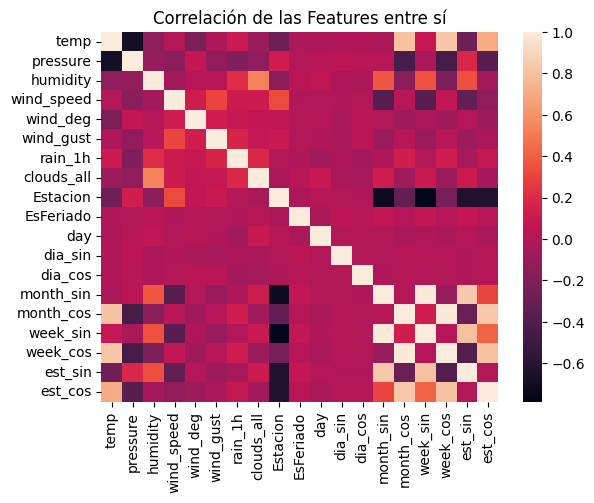

In [171]:
sns.heatmap(X_train_scaled.corr(method = 'pearson'), annot = False)
plt.title("Correlación de las Features entre sí")

In [205]:
#Eliminamos estación
X_train_scaled.drop('Estacion', axis = 1, inplace = True)
X_test_scaled.drop('Estacion', axis = 1, inplace = True)

#Eliminamos presion
X_train_scaled.drop('pressure', axis = 1, inplace = True)
X_test_scaled.drop('pressure', axis = 1, inplace = True)

In [206]:
#Eliminamos week_sin y week_cos, al final tienen alta relación con month_sin y month_cos
X_train_scaled.drop(columns= ['week_sin', 'week_cos'], axis = 1, inplace = True)
#X_test_scaled.drop(columns = ['week_sin', 'week_cos'], axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlación de las Features entre sí')

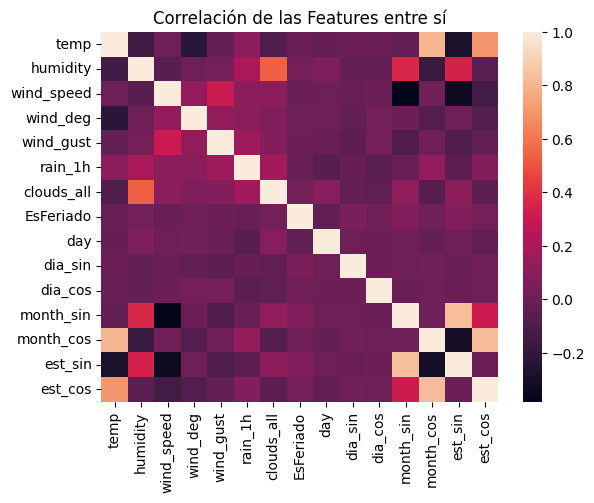

In [174]:
sns.heatmap(X_train_scaled.corr(method = 'pearson'), annot = False)
plt.title("Correlación de las Features entre sí")

Text(0.5, 1.0, 'Correlación Features con Objetivo - Pearson')

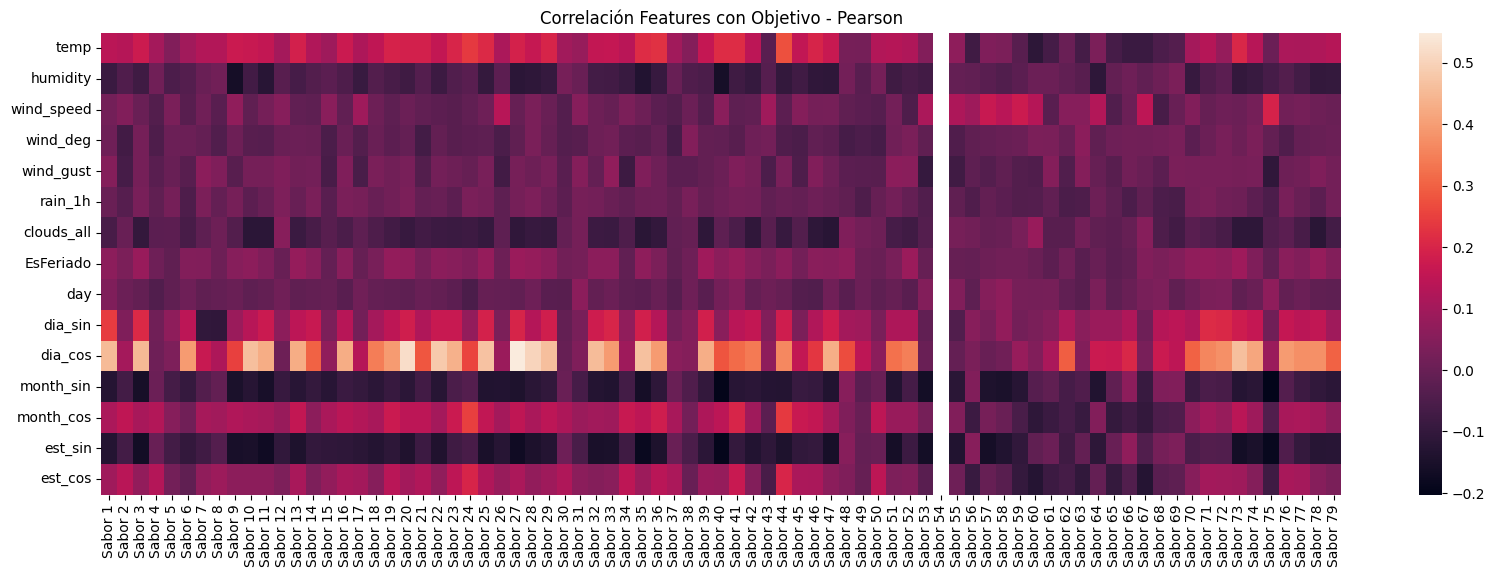

In [175]:
plt.figure(figsize=(20, 6))
sns.heatmap(X_train_scaled.join(y_train.iloc[:, :], how = 'inner').corr(method='pearson').iloc[:15, 15:], annot = False)
plt.title("Correlación Features con Objetivo - Pearson")

Aun hay variables que no son del todo significativas. Las eliminamos.

In [207]:
#Eliminamos wind_deg
X_train_scaled.drop('wind_deg', axis = 1, inplace = True)
X_test_scaled.drop('wind_deg', axis = 1, inplace = True)

#Eliminamos wind_gust
X_train_scaled.drop('wind_gust', axis = 1, inplace = True)
X_test_scaled.drop('wind_gust', axis = 1, inplace = True)

#Eliminamos rain_1h
X_train_scaled.drop('rain_1h', axis = 1, inplace = True)
X_test_scaled.drop('rain_1h', axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlación Features con Objetivo - Pearson')

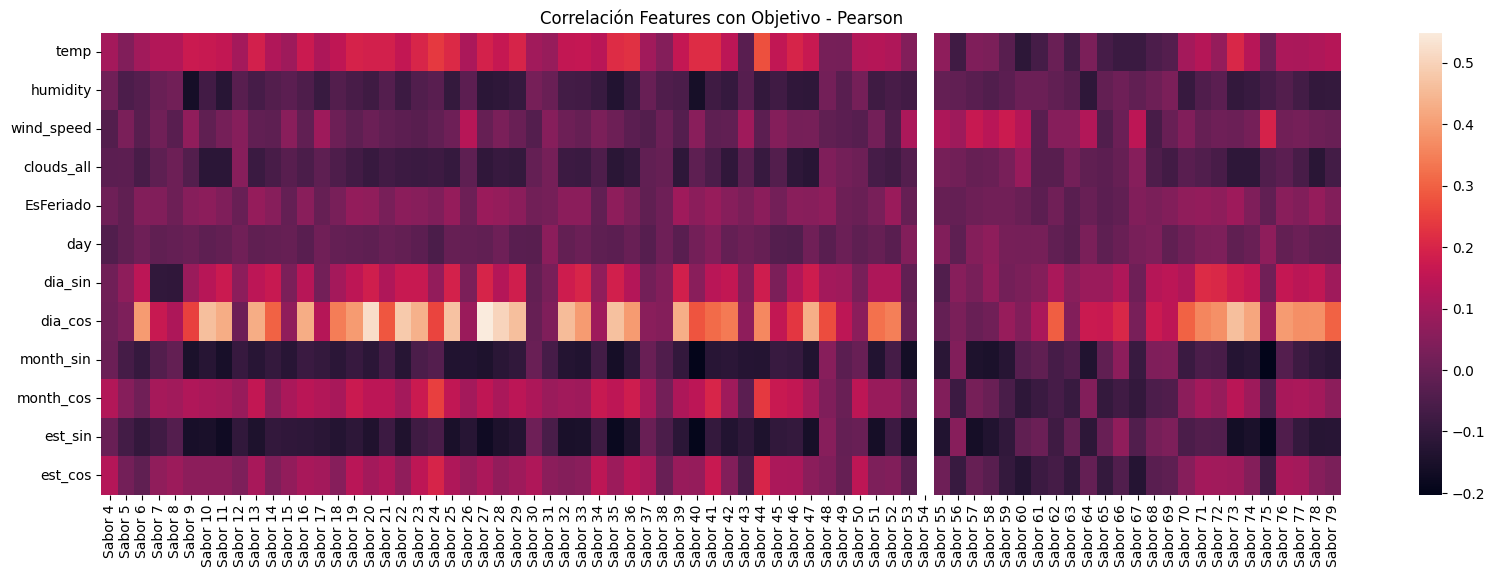

In [177]:
plt.figure(figsize=(20, 6))
sns.heatmap(X_train_scaled.join(y_train.iloc[:, :], how = 'inner').corr(method='pearson').iloc[:12, 15:], annot = False)
plt.title("Correlación Features con Objetivo - Pearson")

In [208]:
y_train.drop('Sabor 54', axis = 1, inplace = True)
y_test.drop('Sabor 54', axis = 1, inplace = True)

C:\Users\IA-41\AppData\Local\Temp\ipykernel_22896\2500907863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.drop('Sabor 54', axis = 1, inplace = True)
C:\Users\IA-41\AppData\Local\Temp\ipykernel_22896\2500907863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.drop('Sabor 54', axis = 1, inplace = True)


In [209]:
X_train_scaled.columns

Index(['temp', 'humidity', 'wind_speed', 'clouds_all', 'EsFeriado', 'day',
       'dia_sin', 'dia_cos', 'month_sin', 'month_cos', 'est_sin', 'est_cos'],
      dtype='object')

# Entrenar XGBoost para Sabor 1

In [181]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# ── 1. Parámetros básicos ────────────────────────────────────────────
lookback = 90      # lags preictores
horizon  = 14      # días a pronosticar
target   = 'Sabor 1'

In [182]:
df_full = pd.concat([X_train_scaled, y_train[target]], axis = 1)

In [186]:

# ── 2. Función para armar dataset supervisado multivariado ───────────
def make_supervised_multivar(df, target_col, lags=60, horiz=14):
    """
    Para cada columna de df:
        - genera columnas lag_1 … lag_L
        - genera rolling mean / std (7 días, opcional)
    Devuelve X (features) y y (target horizon pasos)
    """
    feats = []
    for col in df.columns:
        tmp = pd.DataFrame(index=df.index)
        # lags
        for i in range(1, lags + 1):
            tmp[f'{col}_lag_{i}'] = df[col].shift(i)
        # rolling de 7 (puedes agregar más)
        tmp[f'{col}_roll7_mean'] = df[col].rolling(7).mean().shift(1)
        tmp[f'{col}_roll7_std']  = df[col].rolling(7).std().shift(1)
        feats.append(tmp)
    X = pd.concat(feats, axis=1)

    # objetivos solo del target
    y = pd.concat(
        {f'{target_col}_t_plus_{h}': df[target_col].shift(-h)
         for h in range(1, horiz + 1)},
        axis=1
    )
    return pd.concat([X, y], axis=1).dropna()

# ── 3. Construir el dataset ──────────────────────────────────────────
full_data = make_supervised_multivar(df_full.iloc[:, :13].astype('float32'),
                                     target_col=target,
                                     lags=lookback,
                                     horiz=horizon)

X = full_data.filter(regex='_lag_|_roll')   # todas las features
y = full_data.filter(regex=f'^{target}_t_plus_')

In [187]:
# ── 4. Split temporal (20 % final para validación) ───────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# ── 5. Modelo XGBoost (14 salidas) ───────────────────────────────────
xgb_params = dict(
    n_estimators      = 500,      # ajusta luego con early-stopping
    learning_rate     = 0.05,
    max_depth         = 5,
    subsample         = 0.8,
    colsample_bytree  = 0.8,
    objective         = 'reg:squarederror',
    tree_method       = 'hist',   # rápido en CPU
    random_state      = 42,
)

base   = XGBRegressor(
    #**xgb_params
    )
model  = MultiOutputRegressor(base
                              #, n_jobs=-1
                              )  # 14 modelos en paralelo

model.fit(X_train, y_train)

# ── 6. Evaluación ───────────────────────────────────────────────────
pred_val = model.predict(X_val)
mae      = mean_absolute_error(y_val, pred_val)
print(f"MAE validación (prom. 14 días): {mae:.3f}")

# ── 7. Pronóstico a futuro ──────────────────────────────────────────
last_row = X.tail(1)
forecast  = model.predict(last_row)[0]  # ndarray (14,)
print("Pronóstico Sabor 1 – próximos 14 días:", forecast)

MAE validación (prom. 14 días): 7.879
Pronóstico Sabor 1 – próximos 14 días: [17.352686  27.073706  13.188283  18.41413   14.246317  18.430054
 14.7208185 15.771076  15.387609  26.415218  39.438778  17.360483
 25.891796  13.56924  ]


<Axes: >

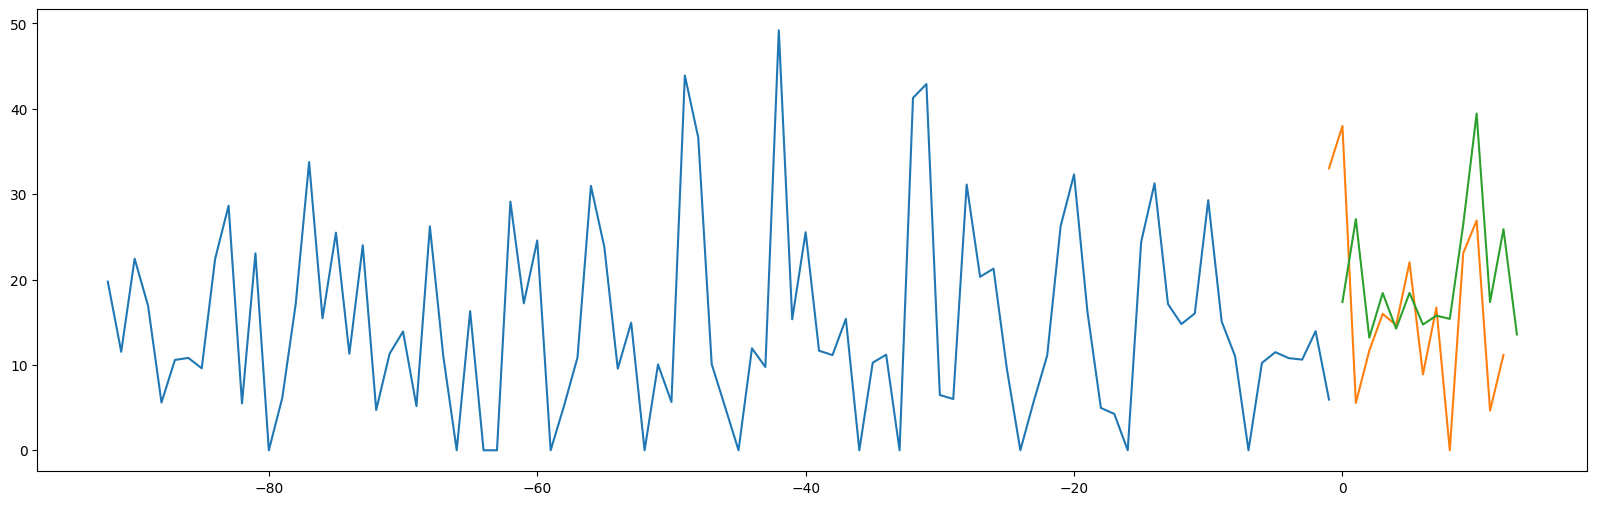

In [188]:
produccionHasta60diasAntes = X.tail(1).iloc[:, 1104:].values[0]
produccion14diasDespues = y.tail(1).values[0]
produccionPredicha = forecast

plt.figure(figsize=(20,6))
sns.lineplot(x =range(-len(produccionHasta60diasAntes), 0), y = produccionHasta60diasAntes)
sns.lineplot(x = range(-1, len(produccion14diasDespues)-1), y = produccion14diasDespues)
sns.lineplot(x = range(14), y = produccionPredicha)

In [193]:
df_full

,temp,humidity,wind_speed,clouds_all,EsFeriado,day,dia_sin,dia_cos,month_sin,month_cos,est_sin,est_cos,Sabor 1
0,0.744146,0.485714,0.212880,0.400,True,1,0.000000,1.000000,0.0,1.000000,0.0,1.000000e+00,5.36
1,0.744365,0.714286,0.150268,0.005,False,2,0.433884,-0.900969,0.0,1.000000,0.0,1.000000e+00,22.92
2,0.826019,0.528571,0.104651,0.000,False,3,0.433884,-0.900969,0.0,1.000000,0.0,1.000000e+00,34.39
3,0.778932,0.557143,0.363596,0.000,False,4,-0.781831,0.623490,0.0,1.000000,0.0,1.000000e+00,10.66
4,0.689244,0.335714,0.357335,0.000,False,5,0.781831,0.623490,0.0,1.000000,0.0,1.000000e+00,11.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.699230,0.314286,0.520572,0.000,False,13,-0.781831,0.623490,-0.5,0.866025,-1.0,-1.836970e-16,0.00
1078,0.687203,0.314286,0.288909,0.000,False,14,0.000000,1.000000,-0.5,0.866025,-1.0,-1.836970e-16,23.08
1079,0.672012,0.471429,0.288909,0.000,False,15,0.781831,0.623490,-0.5,0.866025,-1.0,-1.836970e-16,26.91
1080,0.592967,0.328571,0.600179,0.000,False,16,0.974928,-0.222521,-0.5,0.866025,-1.0,-1.836970e-16,4.65


In [189]:
import joblib

# ── Guardar ───────────────────────────────────────
joblib.dump(model, '../models/xgb_sabor1_multi.pkl')
# genera un archivo ~ (decenas de MB, depende de n_estimators y lags)

# ── Cargar más tarde ──────────────────────────────
model_loaded = joblib.load('../models/xgb_sabor1_multi.pkl')

# probar que funciona
pred_test = model_loaded.predict(X_test)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Dia Semana: object, Estacion: object

# Optimización de hiperparámetros

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

# ── 1. Espacio de búsqueda mínimo (2×2×2 = 8) ────────────────────
param_grid = {
    'estimator__n_estimators' : [400, 800],    # pocas y “medias” rondas
    'estimator__learning_rate': [0.05, 0.10],  # paso corto vs medio
    'estimator__max_depth'    : [4, 6],        # árbol compacto vs normal
}

# ── 2. Modelo base — CPU-friendly ─────────────────────────────────
xgb = XGBRegressor(
    objective   = 'reg:squarederror',
    tree_method = 'hist',     # rápido en CPU
    random_state= 42,
)

multi = MultiOutputRegressor(xgb, n_jobs=-1)

# ── 3. Validación temporal simple ────────────────────────────────
tscv     = TimeSeriesSplit(n_splits=2)
mae_neg  = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator = multi,
    param_grid= param_grid,
    cv        = tscv,
    scoring   = mae_neg,
    verbose   = 1,
    n_jobs    = -1,           # pon 1 si tu CPU se ahoga
)

grid.fit(X_train, y_train)

print(f"Mejor MAE CV: {-grid.best_score_:0.3f}")
print("Mejores hiperparámetros:", grid.best_params_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Mejor MAE CV: 8.693
Mejores hiperparámetros: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 4, 'estimator__n_estimators': 400}


In [ ]:
best_xgb = grid.best_estimator_.estimator
best_xgb.set_params(
    n_estimators=1500,          # grande, para que el ES decida
    early_stopping_rounds=25
)

multi_best = MultiOutputRegressor(best_xgb, n_jobs=-1)
multi_best.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("MAE validación final:",
      mean_absolute_error(y_val, multi_best.predict(X_val)).round(3))


XGBoostError: [15:30:04] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:54: Check failed: info.labels.Size() == preds.Size() (782 vs. 10948) : Invalid shape of labels.